In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
## download vgg weights
vgg = applications.VGG16(input_shape=(256,256,3), weights='imagenet', include_top=False)


Using TensorFlow backend.


In [2]:
import pandas as pd
df=pd.read_csv('./data/study_list.csv',sep=',')
del df['Unnamed: 0']
#print(df['Patient ID'])
cols=df.columns.tolist()
#print(df['Treatment'].unique())
print(len(df.index))
index_labels=dict([(idx,l) for idx, l in zip(df['Patient ID'], df['Site of primary STS']) ])
print(index_labels.items())
print(df['Site of primary STS'].unique())
df.head()

18
dict_items([('STS_037', 'right parascapusular'), ('STS_034', 'right buttock'), ('STS_021', 'right thigh'), ('STS_023', 'left thigh'), ('STS_024', 'left thigh'), ('STS_005', 'left biceps'), ('STS_012', 'right thigh'), ('STS_029', 'left thigh'), ('STS_031', 'right buttock'), ('STS_003', 'right buttock'), ('STS_048', 'left thigh'), ('STS_020', 'left thigh'), ('STS_041', 'parascapusular'), ('STS_015', 'right thigh'), ('STS_002', 'left buttock'), ('STS_011', 'right thigh'), ('STS_039', 'left thigh'), ('STS_022', 'left thigh')])
['left buttock' 'right buttock' 'left thigh' 'right parascapusular'
 'parascapusular' 'left biceps' 'right thigh']


,Age,Grade,Histological type,MSKCC type,"Outcome (recurrence, mets)",Patient ID,Sex,Site of primary STS,"Status (NED, AWD, D)",Study Date,Study Time,Time – MRI scan to PET scan (days),Time – diagnosis to MRI scan (days),Time – diagnosis to last follow-up (days),Time – diagnosis to outcome (days),Treatment
0,61,High,pleiomorphic leiomyosarcoma,Leiomyosarcoma,--,STS_002,Male,left buttock,NED,20060128,145427,25,-10,501,--,Radiotherapy + Surgery
1,17,Intermediate,epithelioid sarcoma,Other,--,STS_003,Female,right buttock,NED,20050415,111853,15,-13,756,--,Radiotherapy + Surgery
2,48,High,pleiomorphic leiomyosarcoma,Leiomyosarcoma,--,STS_024,Male,left thigh,NED,20050101,150247,8,-4,819,--,Radiotherapy + Surgery
3,47,Intermediate,myxofibrosarcoma,MFH,--,STS_029,Female,left thigh,NED,20051104,132025,28,-4,574,--,Radiotherapy + Surgery
4,70,Intermediate,synovial sarcoma,Synovial sarcoma,Mets – lungs,STS_031,Female,right buttock,D,20041208,123133,19,10,804,94,Surgery + Chemotherapy


(256, 256)


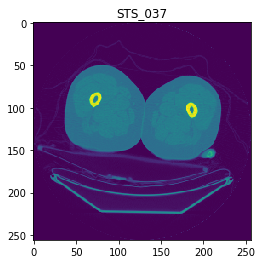

(256, 256)


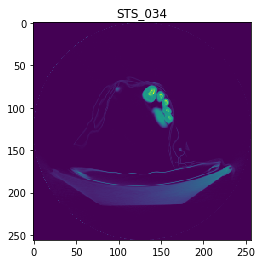

(256, 256)


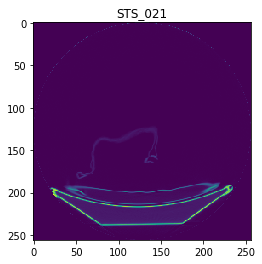

(256, 256)


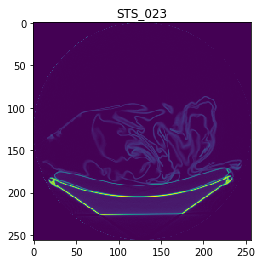

(256, 256)


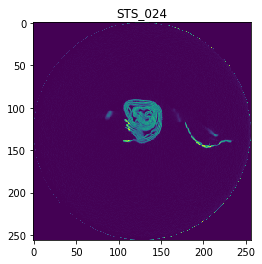

(256, 256)


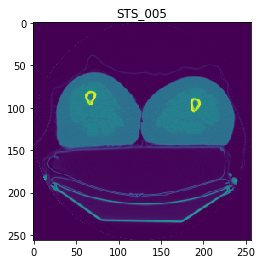

(256, 256)


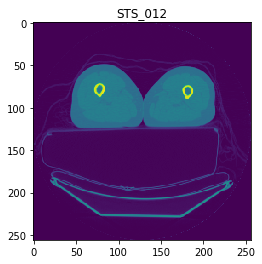

(256, 256)


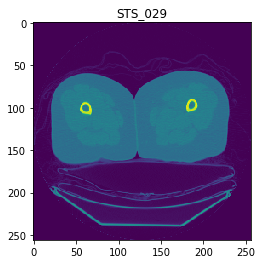

(256, 256)


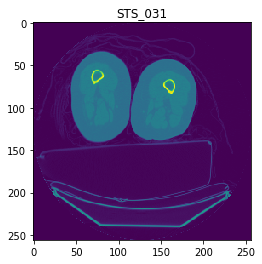

(256, 256)


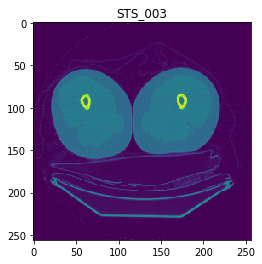

(256, 256)


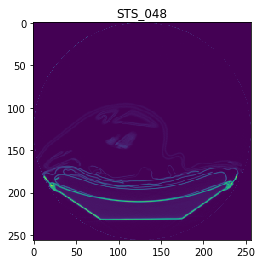

(256, 256)


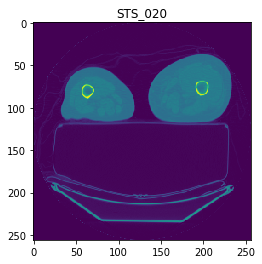

(256, 256)


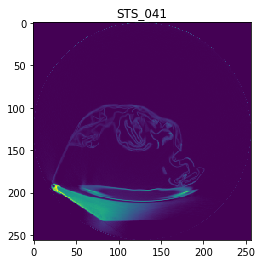

(256, 256)


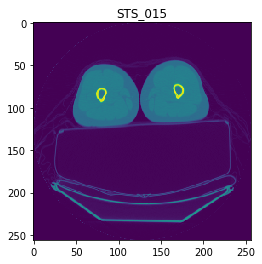

(256, 256)


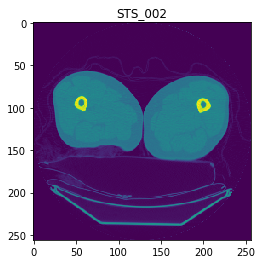

(256, 256)


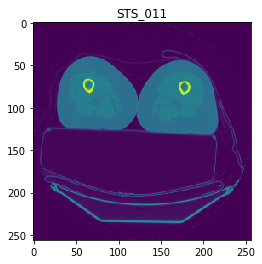

(256, 256)


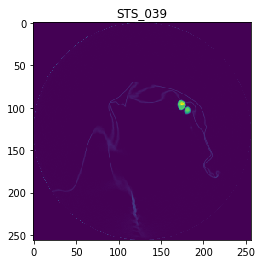

(256, 256)


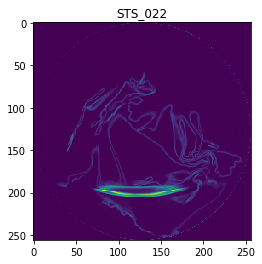

In [3]:
## data source:https://www.kaggle.com/kmader/viewing-the-data/data
import h5py

import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
f=h5py.File('./data/patient_images_lowres.h5','r')
PIDs=list(f['ct_data'])

import cv2
data_images=[]
for item in list(index_labels.keys()):
    #temp=[ f['ct_data'][item][i]/255. for i in range(3)]
    #tmp=np.stack(temp, axis=0)
    tmp=f['ct_data'][item][0]
    print( tmp.shape)
    tmp=tmp.reshape(256,256)
    data_images.append(np.array(tmp))
    #plt.savefig('./data/images/{}.jpg'.format(item))
    plt.imshow(np.array(tmp))
    plt.title(item)
    plt.show()

In [4]:
## convert min max from - 1157  to between 0 and 255
mins=[ np.amin(data_images[i]) for i in range(len(data_images))]
maxs=[np.amax(data_images[i]) for i in range(len(data_images))]
min(mins), max(maxs)
def convertMinMax(OldValue):
    OldMax=max(maxs)
    OldMin=min(mins)
    NewMax=255
    NewMin=0
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue
#create a func that can be used in 2D numpy array to do element wised numerical operation
func=lambda t: convertMinMax(t)

In [ ]:
"""
# actual conersion

converted=[]
func=lambda t: convertMinMax(t)
for i in range(len(data_images)):
    arr=data_images[i]
    newarr=np.array([func(t) for t in arr])
    newarr=newarr.reshape(256,256)

    converted.append(newarr)
"""    

In [5]:
# convert gray to color numpy array with 3 channels
import skimage.color as skc
def gray2rgb(image):
    """
    Grayscale scale image to RGB image
    
    >>> image = np.eye(3, dtype='uint8') * 255
    >>> gray2rgb(image)
    array([[[255, 255, 255],
            [  0,   0,   0],
            [  0,   0,   0]],
    <BLANKLINE>
           [[  0,   0,   0],
            [255, 255, 255],
            [  0,   0,   0]],
    <BLANKLINE>
           [[  0,   0,   0],
            [  0,   0,   0],
            [255, 255, 255]]], dtype=uint8)

    :param numpy array image: Numpy array with range [0,255] and dtype 'uint8'. 
    :return: RGB image
    :rtype:  numpy array with range [0,255] and dtype 'uint8'
    """
    image=image.astype('uint8')
    return skc.gray2rgb(image) 

In [ ]:
"""
newi=gray2rgb(converted[0].astype('uint8'))
newi.shape
%matplotlib inline
plt.imshow(newi)
plt.show()
"""

In [6]:
del data_images

In [ ]:
"""
# check if it is coverted properly to 3 color channels
X=[]
for item , label in zip(converted,list(index_labels.keys())) :
    newimg=gray2rgb(item)
    #plt.savefig('./data/images/{}.jpg'.format(label))
    X.append(newimg)
    plt.title(label)
    plt.imshow(newimg)
    plt.show()
"""

In [7]:
df.groupby(['Site of primary STS']).nunique()

,Age,Grade,Histological type,MSKCC type,"Outcome (recurrence, mets)",Patient ID,Sex,Site of primary STS,"Status (NED, AWD, D)",Study Date,Study Time,Time – MRI scan to PET scan (days),Time – diagnosis to MRI scan (days),Time – diagnosis to last follow-up (days),Time – diagnosis to outcome (days),Treatment
Site of primary STS,,,,,,,,,,,,,,,,
left biceps,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
left buttock,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
left thigh,6,2,5,2,3,7,2,1,3,7,7,6,5,7,5,2
parascapusular,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
right buttock,3,2,3,2,3,3,2,1,2,3,3,3,3,3,3,2
right parascapusular,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
right thigh,4,2,4,4,3,4,2,1,3,4,4,3,4,4,3,2


In [8]:
howmany={'left buttock':1, 'right buttock':3, 'left thigh':7, 'right parascapusular':1,
 'parascapusular':1, 'left biceps':1,'right thigh':4}
howmany.items()

dict_items([('left buttock', 1), ('right buttock', 3), ('right parascapusular', 1), ('left biceps', 1), ('right thigh', 4), ('parascapusular', 1), ('left thigh', 7)])

In [9]:
def y_to_ohe(y, num_class=7):
    return np.eye(num_class)[y.reshape(-1)]

In [10]:
lookup={'left buttock':0, 'right buttock':1, 'left thigh':2, 'right parascapusular':3,
 'parascapusular':4, 'left biceps':5,'right thigh':6}
lookup_reversed=dict([(lookup[index_labels[pid]],index_labels[pid]) for pid in list(index_labels.keys())])
reversed_lookup=dict([(pid, lookup[index_labels[pid]]) for pid in list(index_labels.keys())])
reversed_lookup.items()

dict_items([('STS_021', 6), ('STS_034', 1), ('STS_002', 0), ('STS_023', 2), ('STS_003', 1), ('STS_039', 2), ('STS_012', 6), ('STS_029', 2), ('STS_031', 1), ('STS_037', 3), ('STS_048', 2), ('STS_020', 2), ('STS_041', 4), ('STS_024', 2), ('STS_015', 6), ('STS_011', 6), ('STS_005', 5), ('STS_022', 2)])

In [11]:
import random
def get_samples(label,df):
    subdf=df[df['Site of primary STS']==label]
    pid=np.random.choice(subdf['Patient ID'].values.tolist())
    print("selected pid ",pid)
    rn_=random.randint(1,133)
    tmp=f['ct_data'][pid][rn_]
    #print( tmp.shape)
    tmp=tmp.reshape(256,256)
    newarr=np.array([func(t) for t in tmp])
    newarr=newarr.reshape(256,256)
    ### conver to color
    colorarr=gray2rgb(newarr)
    #colorarr=np.expand_dims(colorarr, axis=0)
    print(colorarr.shape)
    y=lookup[index_labels[pid]]
    #y=y_to_ohe(np.array([y]))
    return colorarr, y

#x,y=get_samples('right thigh',df)
#x.shape, y.shape

In [ ]:
howmany['left buttock']

In [12]:
X=[]
Y=[]
for k,v in howmany.items():
    for v in range(howmany[k]):
        x,y= get_samples(k,df)
        X.append(x)
        Y.append(y)

X=np.array(X)

Y=np.array(Y)
print(np.unique(Y, return_counts=True))
X.shape, Y.shape

selected pid  STS_002
(256, 256, 3)
selected pid  STS_003
(256, 256, 3)
selected pid  STS_003
(256, 256, 3)
selected pid  STS_034
(256, 256, 3)
selected pid  STS_037
(256, 256, 3)
selected pid  STS_005
(256, 256, 3)
selected pid  STS_021
(256, 256, 3)
selected pid  STS_011
(256, 256, 3)
selected pid  STS_021
(256, 256, 3)
selected pid  STS_021
(256, 256, 3)
selected pid  STS_041
(256, 256, 3)
selected pid  STS_029
(256, 256, 3)
selected pid  STS_039
(256, 256, 3)
selected pid  STS_048
(256, 256, 3)
selected pid  STS_029
(256, 256, 3)
selected pid  STS_048
(256, 256, 3)
selected pid  STS_039
(256, 256, 3)
selected pid  STS_023
(256, 256, 3)
(array([0, 1, 2, 3, 4, 5, 6]), array([1, 3, 7, 1, 1, 1, 4], dtype=int64))


((18, 256, 256, 3), (18,))

In [ ]:
"""
from keras.applications.vgg16 import preprocess_input
for img in X:
    print("img shape", img.shape)
    img=np.expand_dims(img, axis=0)
    print("expand dim", img.shape)
    preprocess_input(img)
    print("after processing", img.shape)
    """

In [13]:
from keras.utils import to_categorical

Y=to_categorical(Y, 7)


Y.shape , X.shape

((18, 7), (18, 256, 256, 3))

In [ ]:
"""" no need to do upsamdpling since it does not help anyways 
# upsampling the minority class
#2nd class = 0,1,0 
import random
compare2nd=np.array([0.,1.,0.])
compared3rd=np.array([0.,0.,1.])
def upsampling_minorty(X,Y,compared,pos, howmany):
    flag = True
    count=0
    while flag :
        rn=random.randint(0, 17)
        y=Y[rn]
        if np.argmax(y)==pos and count <howmany:
            newx=np.copy(X[rn]).reshape(1,256,256,3)
            X=np.vstack((X,newx))
            Y=np.vstack((Y,y))
            count+=1
        elif count >=howmany:
            flag=False
            break
    return X, Y        
            
X,Y=upsampling_minorty(X,Y,compare2nd,1 ,6)
X,Y=upsampling_minorty(X,Y,compared3rd,2,9)
X.shape, Y.shape 
"""


In [ ]:
# check indeed the classes are balanced
np.sum(Y, axis=0)

In [14]:
img_rows, img_cols = 256, 256

# batch size and # of epoch
batch_size = 10

# Image data generator in keras
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True)

def image_augmentation(X_train, Y_train, batch_size, datagen=datagen):

    datagen.fit(X_train)

    # fits the model on batches with real-time data augmentation:
    return datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True).next()
outx,outy=image_augmentation(X,Y,10)

In [15]:
print(outx.shape, outy.shape)

(10, 256, 256, 3) (10, 7)


In [16]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256, 256
num_classes=7


### Build the network 


for layer in vgg.layers[:-5]:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(500, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(250, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(100, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['top_k_categorical_accuracy']
)

# here's a more "manual" example
#X,Y=image_augmentation(X,Y,33) # do this to random shuffle the dataset
filepath="transfer_learning_best.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, mode='max')
callbacks_list = [checkpoint]
model.fit(X, Y , epochs=3, callbacks=callbacks_list)


Epoch 1/3
18/18 [==============================] - 8s 454ms/step - loss: 10.8998 - top_k_categorical_accuracy: 0.6667

Epoch 00001: saving model to transfer_learning_best.hdf5
Epoch 2/3
18/18 [==============================] - 6s 348ms/step - loss: 7.3269 - top_k_categorical_accuracy: 1.0000

Epoch 00002: saving model to transfer_learning_best.hdf5
Epoch 3/3
18/18 [==============================] - 6s 358ms/step - loss: 8.9545 - top_k_categorical_accuracy: 1.0000

Epoch 00003: saving model to transfer_learning_best.hdf5


In [17]:

for layer in vgg.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(500, activation='sigmoid')(x)
#x = Dropout(0.25)(x)
x = Dense(250, activation='sigmoid')(x)
#x = Dropout(0.15)(x)
x = Dense(100, activation='sigmoid')(x)
prediction = Dense(num_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['top_k_categorical_accuracy']
)
epochs=10
for e in range(epochs):
    x_batch,y_batch= image_augmentation(X,Y,15)
    print(x_batch.shape, y_batch.shape)
    filepath="TransferredLearning_{}_best.hdf5".format(e)
    checkpoint = ModelCheckpoint(filepath,verbose=1, mode='auto')
    callbacks_list = [checkpoint]
    model.fit(x_batch,y_batch,callbacks=callbacks_list)
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

(15, 256, 256, 3) (15, 7)
Epoch 1/1
15/15 [==============================] - 6s 371ms/step - loss: 2.1589 - top_k_categorical_accuracy: 0.4667

Epoch 00001: saving model to TransferredLearning_0_best.hdf5
(15, 256, 256, 3) (15, 7)
Epoch 1/1
15/15 [==============================] - 9s 628ms/step - loss: 1.9382 - top_k_categorical_accuracy: 0.8000

Epoch 00001: saving model to TransferredLearning_1_best.hdf5
(15, 256, 256, 3) (15, 7)
Epoch 1/1
15/15 [==============================] - 9s 570ms/step - loss: 1.7915 - top_k_categorical_accuracy: 0.8000

Epoch 00001: saving model to TransferredLearning_2_best.hdf5
(15, 256, 256, 3) (15, 7)
Epoch 1/1
15/15 [==============================] - 7s 448ms/step - loss: 1.6994 - top_k_categorical_accuracy: 0.8667

Epoch 00001: saving model to TransferredLearning_3_best.hdf5
(15, 256, 256, 3) (15, 7)
Epoch 1/1
15/15 [==============================] - 6s 407ms/step - loss: 1.7762 - top_k_categorical_accuracy: 0.8667

Epoch 00001: saving model to Transfe

(1, 256, 256, 3)
predicted label left thigh


Text(0.5,1,'PID:STS_031 & correct_label:right thigh')

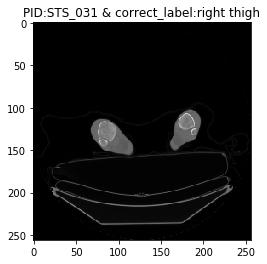

In [18]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
rn=random.randint(0, 18)
test=X[rn]
plt.imshow(test)
test=test.reshape(1,256,256,3)
print(test.shape)
pred=model.predict(test)
y_label=np.argmax(Y[rn])
print("predicted label", lookup_reversed[np.argmax(pred)])
plt.title("PID:{} & correct_label:{}".format(list(reversed_lookup.keys())[rn],lookup_reversed[y_label]))
